<a href="https://colab.research.google.com/github/IvanDePivan/2AMM30-groep-2-component-1/blob/main/Model_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import json
import numpy as np
import spacy
from spacy.training.example import Example #holds information for one training instance
import random
from tqdm import tqdm
from spacy.scorer import Scorer
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix
! pip install -U accelerate
! pip install -U transformers
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:

In [2]:
# Authenticate
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

# Get email of current Colab user
import requests
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
email = gcloud_tokeninfo['email']

Mounted at /content/drive


In [3]:
# Define filepath
if email == 'tamaraexterkate93@gmail.com':
  filename = "/content/drive/MyDrive/TUe/TM/Exports/export_component_1.json"
elif email == 'n.v.diermen@student.tue.nl':
  filename = "/content/drive/MyDrive/Text Mining/export_component_1.json"

In [4]:
DATA = []

# read json file
with open(filename, 'rb') as fp:
  training_data = json.load(fp)

  # get text, labels, relations, benchmark for each article
  for article in training_data:
    entities = []
    id_entities = []
    relations = []
    original_text = article.get('data').get('text')
    if len(article.get('annotations')) == 5: # N=5
      benchmark = True
    else:
      benchmark = False
    for annotation in article.get('annotations'):
      if annotation.get('ground_truth') == True: # only include ground truth
        for ind, label in enumerate(annotation.get('result')):
          if label.get('type') == 'labels':
            start = label.get('value').get('start')
            end = label.get('value').get('end')
            id = label.get('id')
            text = label.get('value').get('text')
            label = label.get('value').get('labels')[0] # note: cannot deal with multiple labels
            id_entities.append((start, end, label, id, text)) # WHY ORDER WEIRD FOR TRAIN[0]?
            entities.append((start, end, label))
          elif label.get('type') == 'relation':
            from_id = label.get('from_id')
            to_id = label.get('to_id')
            relation = label.get('labels')[0] # note: cannot deal with multiple relations
            if relation != "same_as":
              relations.append((from_id, to_id, relation))
          else:
            print("found unknown label type (no label or relation)")

    # append article to training data as dictionary
    DATA.append({
    'text': original_text,
    'entities': entities,
    'id_entities': id_entities,
    'relations': relations,
    'benchmark': benchmark
    })

In [5]:
# Remove entities with smallest span in case of overlapping entities
def remove_overlap(entities):
  # Initialize a list to store the final non-overlapping entities
  final_entities = []

  # Sort the entities by their start position in ascending order
  entities.sort(key=lambda entity: entity[0])

  # Iterate through the sorted entities
  for entity in entities:
      overlaps = False
      for existing_entity in final_entities:
          # Check for overlapping entities
          if (entity[0] >= existing_entity[0] and entity[0] < existing_entity[1]) or \
            (entity[1] > existing_entity[0] and entity[1] <= existing_entity[1]):
              overlaps = True
              break
      if not overlaps:
          final_entities.append(entity)

  return final_entities

for article in DATA:
  article['entities'] = remove_overlap(article['entities'])

In [6]:
def get_distances(DATA):
  # get maximum distances between entities per relation type
  all_distances = {}
  for data in DATA:
    for relation in data['relations']:
      rel_from_begin = [entity[0] for entity in data['id_entities'] if entity[3] == relation[0]]
      rel_to_begin = [entity[0] for entity in data['id_entities'] if entity[3] == relation[1]]
      distance = abs(rel_from_begin[0] - rel_to_begin[0])

      if all_distances.get(relation[2]) == None:
        all_distances[relation[2]] = distance
      else:
        all_distances[relation[2]] = max(all_distances[relation[2]], distance)

  return all_distances

In [7]:
def train_test_split(data, val_size):

  print(f'Total articles: {len(data)}')
  benchmark = [article for article in data if article['benchmark']]
  data = [article for article in data if not article['benchmark']]
  train_end = int(len(data)*(1-val_size))
  train = data[0:train_end]
  val = data[train_end:len(data)]

  print(f'Size train: {len(train)}')
  print(f'Size val: {len(val)}')
  print(f'Size test: {len(benchmark)}')

  return train, val, benchmark

In [8]:
train, val, test =  train_test_split(DATA, val_size=0.25)
max_span_per_relation = get_distances(train)

# obtain the maximum relation span between winner and other entity
max_span = {
'Date': max(max_span_per_relation['born_on'],max_span_per_relation['died_on'],max_span_per_relation['received_nobelprize_in']),
'Prizetype': max_span_per_relation['has_won'],
'Reason': max_span_per_relation['received_nobelprize_for'],
'Nationality': max_span_per_relation['has_nationality']}

special_tokens = ["[WINR]", "[DATE]", "[REAS]", "[NTLY]", "[PRZT]"]

Total articles: 137
Size train: 72
Size val: 25
Size test: 40


In [9]:
def insert_markers(text, pair):

  label_to_marker = {
      'Winner': '[WINR]',
      'Date': '[DATE]',
      'Prizetype': '[PRZT]',
      'Reason': '[REAS]',
      'Nationality': '[NTLY]'
  }

  start_to_add = 0
  end_to_add = 7
  for ent in pair:
    start = ent[0]
    end = ent[1]
    label = ent[2]
    start += start_to_add
    end += end_to_add
    text = text[:start] + label_to_marker[label] + ' ' + text[start:]
    text = text[:end] +' '+ label_to_marker[label] + text[end:]
    start_to_add += 7*2
    end_to_add += 7*2

  return text

In [10]:
def get_relation(pair, relations):
  if pair[0][3] and pair[1][3]: # check if entities of pair exist in annotations
    # see if and what relation there is between the entities of the pair
    for relation in relations:
      if (relation[0] == pair[0][3] and relation[1] == pair[1][3]) or (relation[1] == pair[0][3] and relation[0] == pair[1][3]):
          return relation[2]
  return 'no_relation'

In [11]:
def mark_data(data, NER_output=True, prune = None):

  # init data output and relations list
  data_output = []
  relations_output = []

  # Iterate over each article in data
  for article in data:

    # get original text and convert to doc
    text = article['text']

    # get seperate list of winner entities and other entities in fixed format (start,end,label,id)
    if NER_output:
      # create doc
      doc = best_nlp(text)

      winners = []
      others = []
      for ent in doc.ents:
        # check to what entity in the annotations the NER entity refers to
        for original_ent in article['id_entities']:
          ent_id = None # refer to None if entity is not in annotations
          # otherwise overwrite with id of entity in annotations
          if ent.start_char == original_ent[0] and ent.end_char == original_ent[1]:
            # print(ent.text)
            # print(original_ent[4])
            ent_id = original_ent[3]
            break
        if ent.label_=='Winner':
          winners.append((ent.start_char, ent.end_char, ent.label_, ent_id))
        else:
          others.append((ent.start_char, ent.end_char, ent.label_, ent_id))

    else:
      ents = article['id_entities']
      winners = [ent for ent in ents if ent[2] =='Winner']
      others = [ent for ent in ents if ent[2] !='Winner']

    # make pairs for possible relations (winner + other)
    pairs = []

    for winner in winners:
      for other in others:
        # check if entities are within the maximum relation span of each other
        if prune == None or abs(winner[0]-other[0]) <= prune*max_span[other[2]]:
          if winner[0] < other[0]:
            pairs.append((winner,other))
          else:
            pairs.append((other,winner))

    # create new text with markers for each possible relation with winner
    new_texts = [insert_markers(text, pair) for pair in pairs]
    relations_output.extend([get_relation(pair, article['relations']) for pair in pairs])
    data_output.extend(new_texts)

  return np.array(data_output), np.array(relations_output)

In [12]:
def check_contains_relation(tokens, marker_tokens):
  """Return True if piece of text (tokens) contains a possible relation (= 4 marker tokens)."""

  marker_token_counts = {marker_token: tokens.count(marker_token) for marker_token in marker_tokens}
  nr_marker_tokens = sum(marker_token_counts.values())
  return nr_marker_tokens == 4

def split_paragraphs(X_data, y_data):

  # init
  X_result = []
  y_result = []

  for x, y in zip(X_data, y_data):
    for paragraph in x.split('\n'):
      contains_markers = check_contains_relation(paragraph, special_tokens)
      if contains_markers:
        X_result.append(paragraph)
        y_result.append(y)

  return np.array(X_result), np.array(y_result)

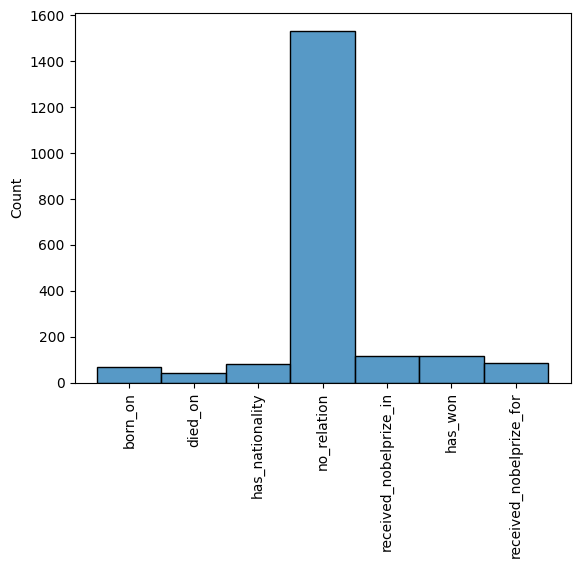

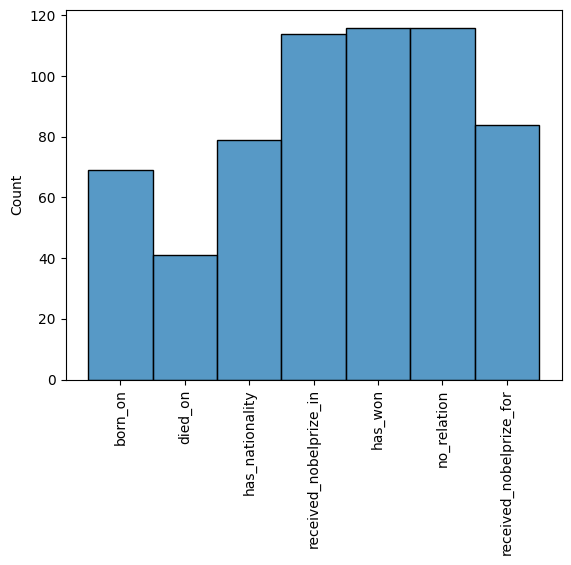

In [13]:
X_train, y_train = mark_data(train, NER_output=False, prune =1.2)
X_val, y_val = mark_data(val, NER_output=False, prune =1.2)
X_test, y_test = mark_data(test, NER_output=False, prune =1.2)

X_train, y_train = split_paragraphs(X_train, y_train)
X_val, y_val = split_paragraphs(X_val, y_val)
X_test, y_test = split_paragraphs(X_test, y_test)

# X_train_full, y_train_full = mark_data(train[1:], NER_output=False)
# X_test_full, y_test_full = mark_data(test, NER_output=False)

# print('Before pruning: \n train: ' + str(len(y_train_full)) + '\n test: '+ str(len(y_test_full)))
# print('After pruning: \n train: ' + str(len(y_train)) + '\n test: '+ str(len(y_test)))

sns.histplot(y_train)
plt.xticks(rotation=90)
plt.show()

def desample(X,y,sample_factor = 1.8):
  # get second highest category
  label_counts = Counter(y)
  relation_counts = label_counts.copy()
  relation_counts.pop('no_relation')
  n_samples = round(sample_factor * max(relation_counts.values())) # allow slight class imbalance for no_relation

  # if no_relation imbalanced, randomly downsample these relations
  if label_counts['no_relation'] - n_samples > 0:
    desample_mask = y != 'no_relation'
    ind_no_relation = np.where(y == 'no_relation')[0]
    include_no_relations = (np.random.choice(ind_no_relation,n_samples, replace = False))
    desample_mask[include_no_relations] = 1
  y = y[desample_mask]
  X = X[desample_mask]

  return X,y

# randomly undersample no_relation in train
X_train, y_train = desample(X_train,y_train, sample_factor =1)

sns.histplot(y_train)
plt.xticks(rotation=90)
plt.show()

id2label = {0: "no_relation", 1: "received_nobelprize_for", 2: "has_won", 3: "received_nobelprize_in", 4: "born_on", 5: "died_on", 6: "has_nationality"}
label2id = {"no_relation": 0, "received_nobelprize_for": 1, "has_won": 2, "received_nobelprize_in": 3, "born_on": 4, "died_on": 5, "has_nationality": 6}

y_train = [label2id[label] for label in y_train]
y_val = [label2id[label] for label in y_val]
y_test = [label2id[label] for label in y_test]

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# add our labels as tokens to vocabulary
num_added_toks = tokenizer.add_tokens(special_tokens)
print('We have added', num_added_toks, 'tokens')

We have added 5 tokens


In [15]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, input_data, labels, tokenizer, max_length):
        self.input_data = input_data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        text = self.input_data[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define hyperparameters
max_seq_length = 128  # You can adjust this as needed
batch_size = 2  # You can adjust this as needed

# Create custom datasets
train_dataset = CustomDataset(X_train, y_train, tokenizer, max_seq_length)
val_dataset = CustomDataset(X_val, y_val, tokenizer, max_seq_length)
test_dataset = CustomDataset(X_test, y_test, tokenizer, max_seq_length)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
import evaluate

accuracy = evaluate.load("accuracy")

In [19]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [20]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=7, id2label=id2label, label2id=label2id
)

model.resize_token_embeddings(len(tokenizer))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30527, 768)

In [21]:
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0,1.0,1.0,1.0,1.0,2.0,1.0], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [22]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.570717,0.594249
2,No log,1.300850,0.485623
3,No log,0.908730,0.651757
4,No log,0.874309,0.709265
5,No log,0.741359,0.744409
6,No log,0.837335,0.731629
7,No log,0.728443,0.792332
8,No log,0.757332,0.798722
9,No log,0.907177,0.766773
10,No log,0.817862,0.785942


TrainOutput(global_step=780, training_loss=0.26417494798317936, metrics={'train_runtime': 250.9326, 'train_samples_per_second': 49.336, 'train_steps_per_second': 3.108, 'total_flos': 410023156485120.0, 'train_loss': 0.26417494798317936, 'epoch': 20.0})

In [23]:
from transformers import AutoConfig
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define filepath to save best model
if email == 'tamaraexterkate93@gmail.com':
  filepath = f"/content/drive/MyDrive/TUe/TM/saved_models/{timestamp}"
elif email == 'n.v.diermen@student.tue.nl':
  filepath = f"/content/drive/MyDrive/Text Mining/saved_models/{timestamp}"

best_model_path = trainer.state.best_model_checkpoint
best_tokenizer = AutoTokenizer.from_pretrained(best_model_path)
best_config = AutoConfig.from_pretrained(best_model_path)
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path, config=best_config).to(device)
best_model.save_pretrained(filepath)
print(f'Best model saved at {filepath}')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Best model saved at /content/drive/MyDrive/TUe/TM/saved_models/20231025-060534


In [24]:
print(best_model_path)

my_awesome_model/checkpoint-273


In [36]:
%cp -r "/content/my_awesome_model/checkpoint-273" "/content/drive/MyDrive/TUe/TM/"

In [25]:
text = "[WINR] Barack Hussein Obama [WINR] II (born August 4, 1961) is an [NTLY] American [NTLY] politician who served as the 44th president of the United States from 2009 to 2017"
inputs = best_tokenizer(text, return_tensors="pt").to(device)

with torch.no_grad():
    logits = best_model(**inputs).logits
    output = best_model(**inputs)

predicted_class_id = logits.argmax().item()
print(model.config.id2label[predicted_class_id])
print(best_model)

has_nationality
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30527, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, 

In [26]:
test_output = trainer.predict(test_dataset)
y_true = test_output[1]
y_pred = np.argmax(test_output[0], axis=1)

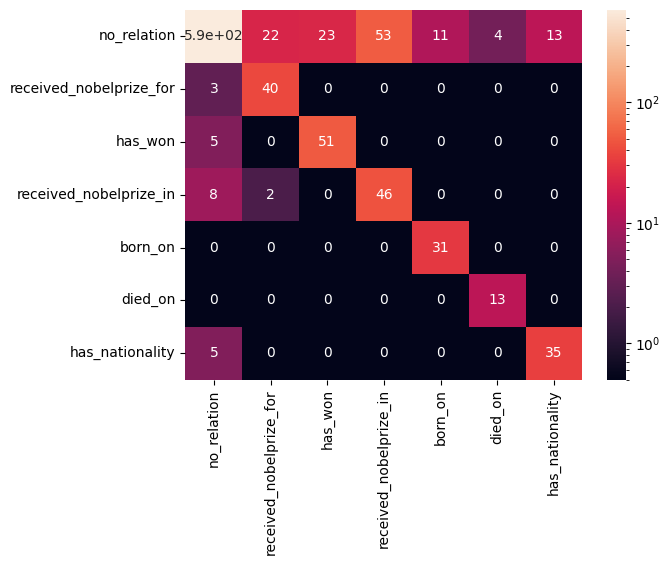

In [27]:
from matplotlib.colors import LogNorm, Normalize

cm = confusion_matrix(y_true,y_pred)
cm_color = np.where(cm==0,0.5,cm)
sns.heatmap(cm_color, annot=cm, xticklabels = id2label.values(), yticklabels = id2label.values(), norm=LogNorm(vmin=0.5))

plt.show()

In [57]:
# label2id = {"no_relation": 0, "received_nobelprize_for": 1, "has_won": 2, "received_nobelprize_in": 3, "born_on": 4, "died_on": 5, "has_nationality": 6}

pred = np.where(y_pred == label2id["has_nationality"])
true = np.where(y_true == label2id["no_relation"])
wrong_pred = (np.intersect1d(pred, true))
print(wrong_pred)
example = wrong_pred[0]
print(X_test[example])
print(y_test[example])


[ 78 138 157 241 242 294 418 521 533 553 588 739 741]
[WINR] Kao [WINR] was born in Shanghai. His family settled in [NTLY] British [NTLY] Hong Kong in 1949. He graduated from Saint Joseph's College in Hong Kong in 1953 and went to London to study electrical engineering. In the 1960s, Kao worked at Standard Telecommunication Laboratories, the research center of Standard Telephones and Cables (STC) in Harlow, and it was here in 1966 that he laid the groundwork for fiber optics in communication. Known as the "godfather of broadband", the "father of fiber optics", and the "father of fiber optic communications", he continued his work in Hong Kong at the Chinese University of Hong Kong, and in the United States at ITT (the parent corporation for STC) and Yale University. Kao was awarded the 2009 Nobel Prize in Physics for "groundbreaking achievements concerning the transmission of light in fibers for optical communication". In 2010, he was knighted by Queen Elizabeth II for "services to fibe

In [28]:
# %cd /content/drive/MyDrive/TUe/TM/SMV

In [29]:
# # ! git clone https://github.com/DFKI-NLP/SMV.git
# ! git pull
# ! pip install -r "requirements.txt"

In [30]:
# %cd SMV

In [31]:
# ! pip install thermostat
# from src.search_methods import fastexplain as fe

# config_path = "configs/toy_dev.yml"
# explanation_string = fe.explain(config_path)
# for explanation in explanation_string:
#     print(explanation)